# Validation tests

In [1]:
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
import h5py
import qutip as qtp
from rqutils.qprint import qprint

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport qudit_sim

## Single-qutrit Hamiltonian

In [4]:
hgen = qudit_sim.HamiltonianGenerator(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.generate()

[]

By default, frame frequencies are set to free-qudit level gaps (qudit frame). Single qudit with no drive will therefore evolve with a null Hamiltonian.

If we move to the "lab frame":

In [5]:
hgen.set_frame('q0', frequency=np.zeros(2))
hgen.generate()

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[  0.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 192.]]]

Adding a constant drive

In [6]:
hgen.add_drive('q0', frequency=99., amplitude=0.5+0.5j)
hamiltonian = hgen.generate()
print(len(hamiltonian))

5


In [7]:
qprint(hamiltonian[0].full(), 'pauli', lhs_label=r'H_{\mathrm{static}}')

In [8]:
qprint(hamiltonian[1][0], 'pauli', amp_norm=(1., f'{hamiltonian[1][1]}*'))

## Parameters from `ibmq_lima`

In [2]:
params_orig = {'delta0': -2109526390.232452,
 'delta1': -2000246532.4219205,
 'delta2': -2096093619.9138844,
 'delta3': -2081254439.3432896,
 'delta4': -2101534832.5639515,
 'jq0q1': 11088625.669671271,
 'jq1q2': 11792549.39343634,
 'jq1q3': 11913891.984976945,
 'jq3q4': 11656329.753118027,
 'omegad0': 1588538050.4400413,
 'omegad1': 1305787281.3336856,
 'omegad2': 1402177549.1160629,
 'omegad3': 1553798885.4251251,
 'omegad4': 1555145151.5021167,
 'wq0': 31602900677.68124,
 'wq1': 32218187482.363426,
 'wq2': 32970108859.848026,
 'wq3': 33314625039.25904,
 'wq4': 31994952868.608166}

## Test: Hamiltonian definition

In [3]:
hgen = RWAHamiltonianGenerator(0, params_orig)
print('Hint', hgen.hint)
print('Hdrive', hgen.hdrive)

Hint []
Hdrive []


In [4]:
params = dict(params_orig)
params['crosstalk'] = {(0, 1): 0.8, (1, 0): 0.6j}
hgen = RWAHamiltonianGenerator((0, 1), params, num_levels=3)

print('Hint', hgen.hint)

Hint [[Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[       0.                0.                0.                0.
         0.                0.                0.                0.
         0.        ]
 [       0.                0.                0.         11088625.66967127
         0.                0.                0.                0.
         0.        ]
 [       0.                0.                0.                0.
         0.                0.                0.                0.
         0.        ]
 [       0.         11088625.66967127        0.                0.
         0.                0.                0.                0.
         0.        ]
 [       0.                0.                0.                0.
         0.                0.                0.                0.
         0.        ]
 [       0.                0.                0.                0.
         0.                0.                0.           

## Check: Single qubit resonant pulse simulation

In [5]:
drive_def = {0: {'frequency': params['wq0'], 'amplitude': 0.1}}
e_ops = [qtp.sigmaz()]
result = run_pulse_sim(
    qubits=0,
    params=params_orig,
    drive_def=drive_def,
    tlist=(100, 1),
    e_ops=e_ops)

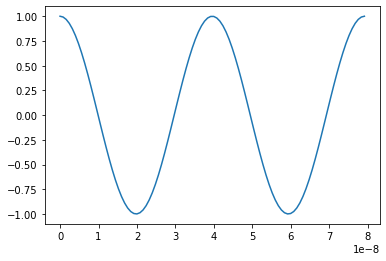

In [6]:
plt.plot(result.times, result.expect[0])

## Check: Single qubit off-resonant pulse simulation

In [7]:
hgen = RWAHamiltonianGenerator(0, params_orig)
hgen.add_drive(0, frequency=params['wq1'], amplitude=0.1)
hamiltonian = hgen.generate()
hamiltonian

[[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
  Qobj data =
  [[0. 0.]
   [1. 0.]],
  '(79426902.52200207+0j) * (cos(615286804.6821861 * t) - 1.j * sin(615286804.6821861 * t))'],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
  Qobj data =
  [[0. 1.]
   [0. 0.]],
  '(79426902.52200207-0j) * (cos(615286804.6821861 * t) + 1.j * sin(615286804.6821861 * t))']]

In [8]:
tlist = hgen.make_tlist(100, 2)
tlist[0], tlist[-1]

(0.0, 2.0423598423909115e-08)

In [9]:
psi0 = (qtp.basis(2, 0) + qtp.basis(2, 1)) / np.sqrt(2.)
e_ops = [qtp.sigmax()]
result = qtp.sesolve(hamiltonian, psi0, tlist, e_ops=e_ops)

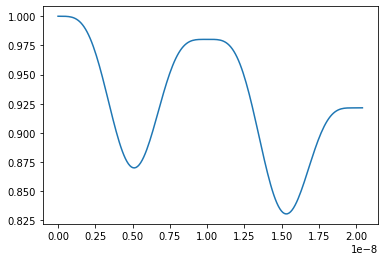

In [10]:
plt.plot(result.times, result.expect[0])

## Check: Two qubit cross resonance, no crosstalk

In [11]:
params = dict(params_orig)

hgen = RWAHamiltonianGenerator((0, 1), params)
hgen.add_drive(0, frequency=params['wq1'], amplitude=0.06)
hamiltonian = hgen.generate()
hamiltonian

[[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
  Qobj data =
  [[       0.                0.                0.                0.        ]
   [       0.                0.         11088625.66967127        0.        ]
   [       0.         11088625.66967127        0.                0.        ]
   [       0.                0.                0.                0.        ]],
  'cos(-615286804.6821861*t)'],
 [Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
  Qobj data =
  [[0.       +0.j         0.       +0.j         0.       +0.j
    0.       +0.j        ]
   [0.       +0.j         0.       +0.j         0.-11088625.66967127j
    0.       +0.j        ]
   [0.       +0.j         0.+11088625.66967127j 0.       +0.j
    0.       +0.j        ]
   [0.       +0.j         0.       +0.j         0.       +0.j
    0.       +0.j        ]],
  'sin(-615286804.6821861*t)'],
 [Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), t

In [12]:
psi0_0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # |00>
psi0_1 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # |10>
tlist = np.linspace(0., 2. * np.pi / params['wq1'] * 1000, 10000)
e_ops = [qtp.tensor(qtp.qeye(2), qtp.sigmay()), qtp.tensor(qtp.qeye(2), qtp.sigmaz())] # IY, IZ
result_0 = qtp.sesolve(hamiltonian, psi0_0, tlist, e_ops=e_ops)
result_1 = qtp.sesolve(hamiltonian, psi0_1, tlist, e_ops=e_ops)

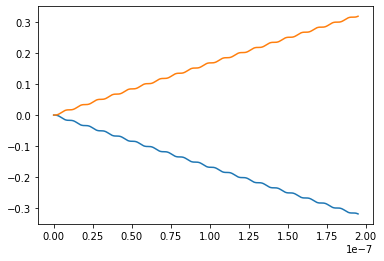

In [13]:
# Cross resonance drive induces a ZX term -> <IY> moves from 0 to opposite directions
plt.plot(tlist, result_0.expect[0])
plt.plot(tlist, result_1.expect[0])

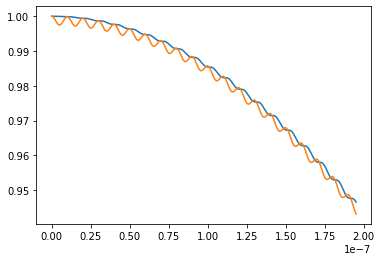

In [14]:
# <IZ> moves from 1 in the same direction
plt.plot(tlist, result_0.expect[1])
plt.plot(tlist, result_1.expect[1])

## Check: Two qubit cross resonance with crosstalk

In [15]:
hamiltonian_noct = hamiltonian

params = dict(params_orig)
params['crosstalk'] = {(0, 1): 0.5 * np.exp(1.j * np.pi / 4.)}

hgen = RWAHamiltonianGenerator((0, 1), params)
hgen.add_drive(0, frequency=params['wq1'], amplitude=0.06)
hamiltonian_withct = hgen.generate()

In [16]:
# Comparing no-ct and with-ct Hamiltonians
print('Number of terms:', len(hamiltonian_noct), len(hamiltonian_withct))
print('Static term (IX) only in with-ct:', hamiltonian_withct[0])
print(hamiltonian_withct[0].full()[0, 1] / (params['omegad0'] / 2. * 0.06), 0.5 * np.exp(1.j * np.pi / 4.))

Number of terms: 4 5
Static term (IX) only in with-ct: Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[       0.               +0.j
  16848990.41458517-16848990.41458516j
         0.               +0.j
         0.               +0.j        ]
 [16848990.41458517+16848990.41458516j
         0.               +0.j
         0.               +0.j
         0.               +0.j        ]
 [       0.               +0.j
         0.               +0.j
         0.               +0.j
  16848990.41458517-16848990.41458516j]
 [       0.               +0.j
         0.               +0.j
  16848990.41458517+16848990.41458516j
         0.               +0.j        ]]
(0.35355339059327373-0.3535533905932737j) (0.3535533905932738+0.35355339059327373j)


In [17]:
print('Interaction term differences:')
print(hamiltonian_noct[0][0].full() - hamiltonian_withct[1][0].full())
print(hamiltonian_noct[0][1], hamiltonian_withct[1][1])
print(hamiltonian_noct[1][0].full() - hamiltonian_withct[2][0].full())
print(hamiltonian_noct[1][1], hamiltonian_withct[2][1])

Interaction term differences:
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
cos(-615286804.6821861*t) cos(-615286804.6821861*t)
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
sin(-615286804.6821861*t) sin(-615286804.6821861*t)


In [18]:
print('Drive term differences:')
print(hamiltonian_noct[2][0].full() - hamiltonian_withct[3][0].full())
print(hamiltonian_noct[2][1], hamiltonian_withct[3][1])
print(hamiltonian_noct[3][0].full() - hamiltonian_withct[4][0].full())
print(hamiltonian_noct[3][1], hamiltonian_withct[4][1])

Drive term differences:
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
(47656141.51320124+0j) * (cos(615286804.6821861 * t) - 1.j * sin(615286804.6821861 * t)) (47656141.51320124+0j) * (cos(615286804.6821861 * t) - 1.j * sin(615286804.6821861 * t))
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
(47656141.51320124-0j) * (cos(615286804.6821861 * t) + 1.j * sin(615286804.6821861 * t)) (47656141.51320124-0j) * (cos(615286804.6821861 * t) + 1.j * sin(615286804.6821861 * t))


In [19]:
hamiltonian = hamiltonian_withct

psi0_0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # |00>
psi0_1 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # |10>
tlist = np.linspace(0., 2. * np.pi / params['wq1'] * 1000, 10000)
e_ops = [qtp.tensor(qtp.qeye(2), qtp.sigmay()), qtp.tensor(qtp.qeye(2), qtp.sigmaz())] # IY, IZ
result_0 = qtp.sesolve(hamiltonian, psi0_0, tlist, e_ops=e_ops)
result_1 = qtp.sesolve(hamiltonian, psi0_1, tlist, e_ops=e_ops)

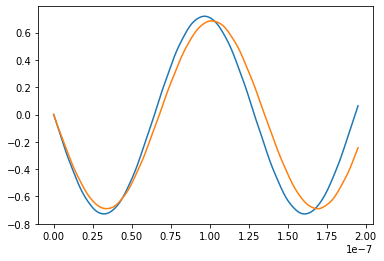

In [20]:
plt.plot(tlist, result_0.expect[0])
plt.plot(tlist, result_1.expect[0])

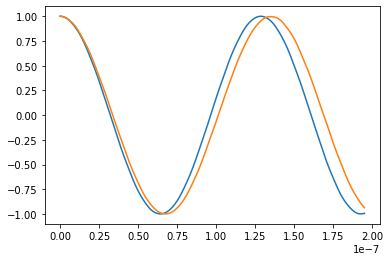

In [21]:
plt.plot(tlist, result_0.expect[1])
plt.plot(tlist, result_1.expect[1])

## Check: Gell-Mann matrices

In [22]:
gmmat = make_generalized_paulis(3, 4)
gmmat

array([[[ 0.81649658+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.81649658+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.81649658+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j]],

       [[ 0.        +0.j,  1.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 1.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j]],

       [[ 0.        +0.j,  0.        -1.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +1.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0

In [23]:
inner_prod = np.tensordot(gmmat, gmmat, ((1, 2), (2, 1)))
inner_prod.shape

(9, 9)

In [24]:
np.any(np.abs(inner_prod - np.eye(9, dtype=np.complex128) * 2.) > 1.e-10)

False

## Check: two-qutrit bases

In [25]:
basis = make_prod_basis(gmmat, 2)
basis.shape

(9, 9, 16, 16)

In [26]:
basis_flat = basis.reshape(-1, *basis.shape[-2:])
inner_prod = np.tensordot(basis_flat, basis_flat, ((-2, -1), (-1, -2)))
inner_prod.shape

(81, 81)

In [27]:
np.any(np.abs(inner_prod - np.eye(inner_prod.shape[0], dtype=np.complex128) * 4.) > 1.e-10)

False

## Check: Heff for qubit 0 off-resonant drive

In [28]:
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.06}}

coeffs = find_heff(
    qubits=0,
    params=params_orig,
    drive_def=drive_def,
    num_sim_levels=2,
    comp_dim=2,
    save_result_to='test',
    log_level=logging.INFO)

coeffs

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 2 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 32218187482.363426 and envelope 0.06
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.021e-06
INFO:qudit_sim.pulse_sim:Hamiltonian with 2 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.883484 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to test.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 142 steps.


array([      0.        ,  282599.8125    ,  -27556.09960938,
       3658773.25      ])

In [29]:
with h5py.File('test.h5', 'r') as source:
    time_evolution = source['time_evolution'][:]
    tlist = source['tlist'][:]

time_evolution.shape

(1000, 2, 2)

In [30]:
generators = matrix_ufunc(lambda u: -np.angle(u), time_evolution)
coeffs_t = extract_coefficients(generators, 2, 1)

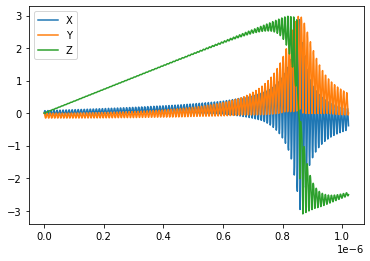

In [31]:
plt.plot(tlist, coeffs_t[:, 1], label='X')
plt.plot(tlist, coeffs_t[:, 2], label='Y')
plt.plot(tlist, coeffs_t[:, 3], label='Z')
plt.legend()

## Check: Heff for cross resonance

In [32]:
params = dict(params_orig)
params['crosstalk'] = {(0, 1): 0.8 * np.exp(-np.pi / 4. * 1.j)}
drive_def = {0: {'frequency': params['wq1'], 'amplitude': 0.01}}

coeffs = find_heff(
    qubits=(0, 1),
    params=params,
    drive_def=drive_def,
    num_sim_levels=2,
    comp_dim=2,
    save_result_to='test_cr',
    log_level=logging.INFO)

coeffs

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 2 qubits and 2 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 2
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 32218187482.363426 and envelope 0.01
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.021e-06
INFO:qudit_sim.pulse_sim:Hamiltonian with 5 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.888409 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to test_cr.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 77 steps.


array([[ 0.00000000e+00,  8.98462500e+06, -8.98487700e+06,
        -1.98848969e+05],
       [ 7.69548633e+03, -1.85096375e+03,  1.62795020e+04,
         7.64502891e+04],
       [-3.75118125e+04, -2.08707168e+04,  1.04073857e+04,
        -8.21936719e+04],
       [ 4.05081750e+05,  2.87278781e+05,  4.05401855e+02,
        -3.30956909e+03]])

In [33]:
with h5py.File('test_cr.h5', 'r') as source:
    time_evolution = source['time_evolution'][:]
    tlist = source['tlist'][:]

time_evolution.shape

(1000, 4, 4)

In [34]:
generators = matrix_ufunc(lambda u: -np.angle(u), time_evolution)
coeffs_t = extract_coefficients(generators, 2, 2)

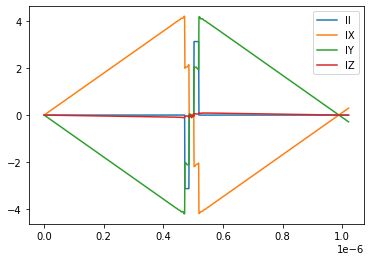

In [35]:
plt.plot(tlist, coeffs_t[:, 0, 0], label='II')
plt.plot(tlist, coeffs_t[:, 0, 1], label='IX')
plt.plot(tlist, coeffs_t[:, 0, 2], label='IY')
plt.plot(tlist, coeffs_t[:, 0, 3], label='IZ')
plt.legend()

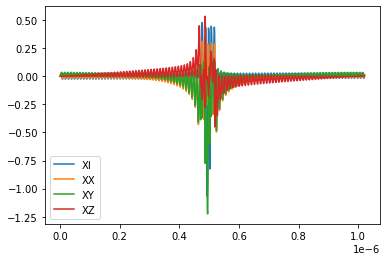

In [36]:
plt.plot(tlist, coeffs_t[:, 1, 0], label='XI')
plt.plot(tlist, coeffs_t[:, 1, 1], label='XX')
plt.plot(tlist, coeffs_t[:, 1, 2], label='XY')
plt.plot(tlist, coeffs_t[:, 1, 3], label='XZ')
plt.legend()

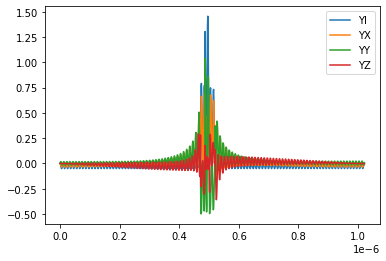

In [37]:
plt.plot(tlist, coeffs_t[:, 2, 0], label='YI')
plt.plot(tlist, coeffs_t[:, 2, 1], label='YX')
plt.plot(tlist, coeffs_t[:, 2, 2], label='YY')
plt.plot(tlist, coeffs_t[:, 2, 3], label='YZ')
plt.legend()

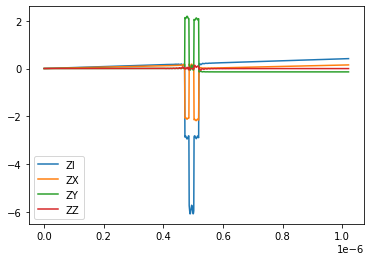

In [38]:
plt.plot(tlist, coeffs_t[:, 3, 0], label='ZI')
plt.plot(tlist, coeffs_t[:, 3, 1], label='ZX')
plt.plot(tlist, coeffs_t[:, 3, 2], label='ZY')
plt.plot(tlist, coeffs_t[:, 3, 3], label='ZZ')
plt.legend()